In [1]:
import argparse
import math
from typing import Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt

import torch

from AssociativeRetrievalTask.data_art import load_data
from Scripts.utils import DATA




In [2]:
class STPNR(torch.nn.Module):
    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            output_size: int,
    ):
        super().__init__()

        # --- Network sizes ---
        self._input_size = input_size
        self._hidden_size = hidden_size
        self._output_size = output_size
        
        self.ei_mask = torch.ones(hidden_size, hidden_size + input_size)
        # Assuming first 4/5 are excitatory and last 1/5 are inhibitory
        num_inhibitory = hidden_size // 5
        self.ei_mask[-num_inhibitory:, :] = -1

        # --- Parameters ---
        init_k = 1 / math.sqrt(self._hidden_size)
        # STP parameters: lambda (decay rate) and gamma (meta-learning rate)
        self.weight_lambda = torch.nn.Parameter(torch.empty(hidden_size, hidden_size + input_size).uniform_(0, 1))
        self.weight_gamma = torch.nn.Parameter(torch.empty(hidden_size, hidden_size + input_size).uniform_(
            -0.001 * init_k, 0.001 * init_k))
        # RNN weight and bias
        self.weight = torch.nn.Parameter(torch.empty(hidden_size, hidden_size + input_size).uniform_(-init_k, init_k))
        self.bias = torch.nn.Parameter(torch.empty(hidden_size).uniform_(-init_k, init_k))
        # Readout layer
        self.hidden2tag = torch.nn.Linear(hidden_size, output_size)

    def forward(self, sentence: torch.Tensor, states: Optional[Tuple[torch.Tensor, torch.Tensor]] = None, collect_states=False):
        # Batch first assumption, seq second
        batch_size, seq_len = sentence.size()[:2]
        #print(seq_lens)
        device = sentence.device
        f_tp1_states = []  # Initialize list to store f_tp1 states

        if states is None:
            # neuronal activations and synaptic states (short-term component F), respectively
            states = (torch.zeros((batch_size, self._hidden_size), device=device),
                      torch.zeros((batch_size, self._hidden_size, self._hidden_size + self._input_size), device=device))

        for seq_element_idx in range(seq_len):
            seq_element = sentence[:, seq_element_idx]
            # treat all presynaptic inputs (neuronal and environment) equally
            total_input = torch.cat((seq_element, states[0]), dim=1)
            # combine fixed and plastic weights into one efficacy matrix G, which is normalised
            total_weights = self.weight + states[1]
            # linear transformation
            h_tp1 = torch.einsum('bf,bhf->bh', total_input, total_weights)

            # compute norm per row (add small number to avoid division by 0)
            norm = torch.linalg.norm(total_weights, ord=2, dim=2, keepdim=True) + 1e-16
            # norm output instead of total_weights for lower memory footprint, add bias and non-linearity
            h_tp1 = torch.tanh(h_tp1 / norm.squeeze(-1) + self.bias)
            # normalise synaptic weights
            f_tp1 = states[1] / norm

            # STP update: scale current memory, add a scaled association between presynaptic and posynaptic activations
            f_tp1 = self.weight_lambda * f_tp1 + self.weight_gamma * torch.einsum('bf,bh->bhf', total_input, h_tp1)
            # update neuronal memories
            states = (h_tp1, f_tp1)
            
            if collect_states:
                f_tp1_states.append(states[1].detach().cpu().numpy())
            

        # readout to get classes scores
        tag_space = self.hidden2tag(h_tp1)
        if collect_states:
            return tag_space, states, f_tp1_states  # Return the additional states
        else:
            return tag_space, states




In [3]:
    batch_size, output_size = 128, 37
    final_f_tp1 = None  # Variable to store the final f_tp1
    # Dataloaders, will generate datasets if not found in DATA path
    train_dataloader, validation_dataloader, test_dataloader = load_data(
        batch_size=batch_size,
        data_path=DATA,
        onehot=True,
        train_size=10000,
        valid_size=5000,
        test_size=1000,
    )

Loading training data...


In [4]:
def main(config):
    batch_size, output_size = 128, 37
    final_f_tp1 = None  # Variable to store the final f_tp1
    # Dataloaders, will generate datasets if not found in DATA path
    """ train_dataloader, validation_dataloader, test_dataloader = load_data(
        batch_size=batch_size,
        data_path=DATA,
        onehot=True,
        train_size=10000,
        valid_size=5000,
        test_size=1000,
    ) """

    device = torch.device(f"cuda:{config['gpu']}") if config['gpu'] > -1 else torch.device('cpu')

    net = STPNR(
        input_size=37,  # alphabet character + digits + '?' sign
        hidden_size=50,
        output_size=output_size,  # predict possibly any character
    )

    # set up learning
    net.to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    n_epochs, best_validation_acc = 100, -float('inf')
    #change to 200
    for i_epoch in range(1, n_epochs + 1):
        for sentence, tags in train_dataloader:
            if sentence.size()[0] != batch_size:
                # drop last batch which isn't full
                continue
            net.zero_grad()
            sentence, tags = sentence.to(device), tags.to(device)
            tag_scores, _ = net(sentence, states=None)
            # flatten the batch and sequences, so all frames are treated equally
            loss = loss_function(tag_scores.view(-1, output_size), tags.view(-1))
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                # First 4/5 are excitatory (E units), set negative weights to 0
                num_excitatory = 4 * net.weight.shape[0] // 5
                net.weight.data[:num_excitatory] = torch.clamp(net.weight.data[:num_excitatory], min=0)

                # Last 1/5 are inhibitory (I units), set positive weights to 0
                num_inhibitory = net.weight.shape[0] // 5
                net.weight.data[-num_inhibitory:] = torch.clamp(net.weight.data[-num_inhibitory:], max=0)

        with torch.no_grad():
            acc = 0
            for sentence, tags in validation_dataloader:
                if sentence.size()[0] != batch_size:
                    continue  # drop last batch which isn't full
                sentence, tags = sentence.to(device), tags.to(device)
                tag_scores, _ = net(sentence, states=None)
                # add correct predictions
                acc += (tag_scores.argmax(dim=1) == tags.to(device)).float().sum().cpu().item()
            # normalise to number of samples in validation set
            last_validation_acc = acc / math.prod(list(validation_dataloader.dataset.tensors[1].size()))
        if last_validation_acc > best_validation_acc:
            best_validation_acc = last_validation_acc
        if i_epoch % 10 == 0:
            print('-' * 45, 'Epoch', i_epoch, '-' * 45)
            print("Best validation accuracy", best_validation_acc)
            print("Last validation accuracy", last_validation_acc)
            print("Last loss", f"{loss.cpu().item():4f}")
            
        if i_epoch == n_epochs:
            sentence, _ = next(iter(validation_dataloader))  # Get a sample batch
            #print(sentence)
            sentence = sentence.to(device)
            _, states = net(sentence, states=None)
            _, _, f_tp1_dynamics = net(sentence, states=None, collect_states=True)
            final_f_tp1 = states[1].detach().cpu().numpy()  
            print(final_f_tp1.shape)
            
            f_tp1_dynamics_array = np.stack(f_tp1_dynamics)

            # Initialize lists to store mean values over time
            e_to_e_means = []
            e_to_i_means = []

            num_inputs = 37  # The number of input units
            num_excitatory = 4 * (f_tp1_dynamics_array.shape[-1] - num_inputs) // 5  # 4/5 are E units

            # Compute mean values over time
            for t in range(f_tp1_dynamics_array.shape[0]):
                current_f_tp1 = f_tp1_dynamics_array[t]
                e_to_e_mean = np.mean(current_f_tp1[:, :num_excitatory, num_inputs:num_excitatory+num_inputs])
                e_to_i_mean = np.mean(current_f_tp1[:, num_excitatory:, num_inputs:num_excitatory+num_inputs])
                e_to_e_means.append(e_to_e_mean)
                e_to_i_means.append(e_to_i_mean)

            # Plotting the dynamics over time
            plt.figure(figsize=(10, 5))
            plt.plot(e_to_e_means, label='E-to-E Mean', color='red')
            plt.plot(e_to_i_means, label='E-to-I Mean', color='blue')
            plt.xlabel('Time Step')
            plt.ylabel('Average Weight')
            plt.title('Dynamics of E-to-E and E-to-I Weights Over Time')
            plt.legend()
            plt.savefig('dynamics_depression.png', dpi=300)
            plt.show()
            
            plt.clf()
           
        num_inputs = 37
        input_size = 37
        if final_f_tp1 is not None:
              # Use the provided input_size
            num_excitatory = 4 * (final_f_tp1.shape[2] - num_inputs) // 5  # 4/5 are E units
    
            # Adjust indices to exclude input weights
            e_to_e_mean = np.mean(final_f_tp1[:, :num_excitatory, num_inputs:num_excitatory+num_inputs])
            e_to_i_mean = np.mean(final_f_tp1[:, num_excitatory:, num_inputs:num_excitatory+num_inputs])
     
            # Plotting the means as bars
            plt.bar(['E-to-E', 'E-to-I'], [e_to_e_mean, e_to_i_mean], color=['red', 'blue'])
            plt.ylabel('Average Weight')
            plt.title('Average Weights in E-I Network')
            plt.savefig('average_weights_EI.png', dpi=300)
            plt.close()

            # Plotting and saving the original weight matrix
            mean_f_tp1 = np.mean(final_f_tp1, axis=0)
            plt.imshow(mean_f_tp1, cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.title('Final f_tp1 Matrix')
            plt.savefig('matrix_syn.png', dpi=300)
            plt.close()
            plt.clf()
         
        if i_epoch == n_epochs:


            # Assuming 'net' is your trained STPNR network
            weight_lambda = net.weight_lambda.detach().cpu().numpy()  # Convert PyTorch tensor to NumPy array
            weight_gamma = net.weight_gamma.detach().cpu().numpy()

            # Compute E-to-E and E-to-I means for lambda and gamma
            num_excitatory = weight_lambda.shape[0] * 4 // 5
            num_inhibitory = weight_lambda.shape[0] // 5

            # Lambda
            lambda_e_to_e_mean = np.mean(weight_lambda[:num_excitatory, input_size:input_size+num_excitatory])
            lambda_e_to_i_mean = np.mean(weight_lambda[:num_excitatory, -num_inhibitory:])

            # Gamma
            gamma_e_to_e_mean = np.mean(weight_gamma[:num_excitatory, input_size:input_size+num_excitatory])
            gamma_e_to_i_mean = np.mean(weight_gamma[:num_excitatory, -num_inhibitory:])

            # Plotting
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))

            # Lambda Weight Matrix
            im = axes[0, 0].imshow(weight_lambda, cmap='hot', interpolation='nearest')
            axes[0, 0].set_title('Lambda Weight Matrix')
            fig.colorbar(im, ax=axes[0, 0])  # Add colorbar correctly

            # Gamma Weight Matrix
            im = axes[0, 1].imshow(weight_gamma, cmap='hot', interpolation='nearest')
            axes[0, 1].set_title('Gamma Weight Matrix')
            fig.colorbar(im, ax=axes[0, 1])  # Add colorbar correctly

            # E-to-E and E-to-I Means for Lambda
            axes[1, 0].bar(['E-to-E', 'E-to-I'], [lambda_e_to_e_mean, lambda_e_to_i_mean], color=['red', 'blue'])
            axes[1, 0].set_title('Lambda: E-to-E and E-to-I Means')
            axes[1, 0].set_ylabel('Average Weight')

            # E-to-E and E-to-I Means for Gamma
            axes[1, 1].bar(['E-to-E', 'E-to-I'], [gamma_e_to_e_mean, gamma_e_to_i_mean], color=['red', 'blue'])
            axes[1, 1].set_title('Gamma: E-to-E and E-to-I Means')
            axes[1, 1].set_ylabel('Average Weight')

            plt.tight_layout()
            plt.savefig('matrix_gamma_lambda.png', dpi=300)
            plt.close()
        

    


--------------------------------------------- Epoch 10 ---------------------------------------------
Best validation accuracy 0.4146
Last validation accuracy 0.4146
Last loss 1.026567
--------------------------------------------- Epoch 20 ---------------------------------------------
Best validation accuracy 0.5676
Last validation accuracy 0.5676
Last loss 0.870467
--------------------------------------------- Epoch 30 ---------------------------------------------
Best validation accuracy 0.8584
Last validation accuracy 0.8584
Last loss 0.507701
--------------------------------------------- Epoch 40 ---------------------------------------------
Best validation accuracy 0.9428
Last validation accuracy 0.9428
Last loss 0.294190
--------------------------------------------- Epoch 50 ---------------------------------------------
Best validation accuracy 0.9672
Last validation accuracy 0.9672
Last loss 0.179306
--------------------------------------------- Epoch 60 -------------------------

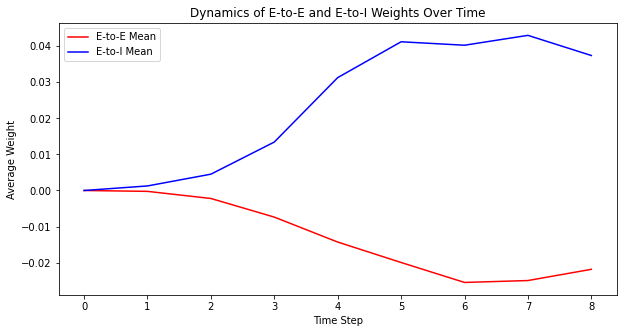

<Figure size 432x288 with 0 Axes>

In [5]:
config = {
    'gpu': 0  # or whichever configuration you need
}

main(config)

usage: ipykernel_launcher.py [-h] [--gpu GPU]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-8b9d5f4d-6470-4aef-a7cb-c774e2c87329.json


SystemExit: 2